In [36]:
import pandas as pd
import wandb
import os 
import sys 
import numpy as np  
from numpy import arange
import matplotlib.pyplot as plt
__file__ = 'wandb_test.ipynd'
os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
api = wandb.Api()
entity, project = "tpn", "final"
runs = api.runs(entity + "/" + project)
RESULTS_DIR = os.path.join(os.path.dirname(__file__), '..', 'results/data')
ALGORITHM_TYPES = ["independent", "centralized", "shared"]
REWARD_TYPES = ["type_1", "type_2", "type_3"]
STEP_PENALTY = [0, 0.01, 0.03]
ALGORITHM_TYPE = "independent"
REWARD_TYPE = "type_1"

This cell prints the performances of the agents in the file > results/stats_PROJECT_NAME_RUNS.txt

In [38]:
_run_stats = dict()
collated_performances_df = pd.DataFrame(
    [],
    columns = ['step_penalty', 'algorithm_type', 'reward_type', 'lstm',
        'episode_length', 'episode_reward', 'epsiode_assists',\
               'eval_length', 'eval_reward', 'eval_assists']
).fillna(0)


for run in runs:
    # if run._state != "finished":
    if run._state != "finished":
        if run._state == "running":
            _run_stats['running_runs'] = _run_stats.get('running_runs', 0) + 1
        else:
            _run_stats['crashed_runs'] = _run_stats.get('crashed_runs', 0) + 1
        continue
    _run_stats['finished_runs'] = _run_stats.get('finished_runs', 0) + 1

    config = run.config
    algo_type = config['algorithm_type']
    reward_type = config['env_config']['reward_type']
    step_penalty = config['env_config']['step_penalty']
    use_lstm = config['training']['model']['use_lstm']
    collated_performances_df.loc[len(collated_performances_df)] = [
        step_penalty,
        algo_type,
        reward_type,
        use_lstm,
        run.summary['episode_len_mean'],
        run.summary['episode_reward_mean'],
        run.summary['episode_assists_mean'],
        run.summary['eval_episode_len'],
        run.summary['eval_reward'],
        run.summary['eval_assists']
    ]

    

print(f"F: {_run_stats.get('finished_runs', 0)}, R: {_run_stats.get('running_runs', 0)}, C: {_run_stats.get('crashed_runs', 0)}")
collated_performances_df = collated_performances_df.groupby(['step_penalty', 'reward_type', 'lstm', 'algorithm_type']).agg(['mean', 'std', 'count'])
with open(f"{RESULTS_DIR}/stats_{project}_{_run_stats.get('finished_runs')}.txt", 'a') as f:
    f.write(f"Finished: {_run_stats.get('finished_runs', 0)}, Running: {_run_stats.get('running_runs', 0)}, Crashed: {_run_stats.get('crashed_runs', 0)}\n")
    f.write(collated_performances_df.to_string())
    f.write("\n\n\n")
collated_performances_df
    

F: 424, R: 96, C: 261


episode_length                   \
                                                        mean        std count   
step_penalty reward_type lstm  algorithm_type                                   
-0.03        type_1      False centralized         51.494000   2.818711     5   
                               independent         52.476000   3.461204     5   
                               shared              87.008000  19.257049     5   
             type_2      False centralized         53.508000   9.434600     5   
                               independent         54.970000  14.722668     5   
                               shared              92.862000  17.068870     5   
             type_3      False centralized         55.108000   5.513581     5   
                               independent         49.422000   2.659092     5   
                               shared              87.014000  19.159577     5   
-0.01        type_1      False centralized         53.541429   5.018304    21   
                               independent         51.558000   3.572592    20   
                               shared              65.080870   4.155747    23   
             type_2      False centralized         56.188000   4.124998    20   
                               independent         50.161000   2.731202    20   
                               shared              66.645714   3.472150    21   
             type_3      False centralized         56.068500   5.750458    20   
                               independent         51.767273   5.258285    22   
                               shared              68.212381   4.116163    21   
 0.00        type_1      False centralized         58.304762   7.943466    21   
                               independent         55.129500   5.012737    20   
                               shared              66.211000   3.481306    20   
             type_2      False centralized         61.406364   7.631702    22   
                               independent         54.509545   4.301472    22   
                               shared              71.116500   3.093287    20   
             type_3      False centralized         61.916087   7.037396    23   
                               independent         56.390000   5.027464    21   
                               shared              68.607727   4.096403    22   

                                              episode_reward                  \
                                                        mean       std count   
step_penalty reward_type lstm  algorithm_type                                  
-0.03        type_1      False centralized          2.987360  0.221745     5   
                               independent          2.971700  0.224510     5   
                               shared              -2.060440  3.699876     5   
             type_2      False centralized          3.081280  0.687597     5   
                               independent          2.971780  1.167211     5   
                               shared              -2.395480  2.943436     5   
             type_3      False centralized          3.477400  0.541695     5   
                               independent          3.746740  0.188340     5   
                               shared              -1.314020  4.036050     5   
-0.01        type_1      False centralized          4.868452  0.176670    21   
                               independent          4.953595  0.126963    20   
                               shared               4.436500  0.209358    23   
             type_2      False centralized          5.026760  0.154401    20   
                               independent          5.230665  0.092042    20   
                               shared               4.949619  0.157458    21   
             type_3      False centralized          5.497780  0.292816    20   
                               independent          5.634486  0.208903    22   
               

This cell builds graphs for reward mean, assits mean and episode len mean for each category
and saves them to results/data/{algo_name}_s{step_penalty}_r{reward_type}_reward.dat

/tmp/ipykernel_43605/1247671905.py:60: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  collated_performances_df = collated_performances_df.rolling(5, axis=0).mean().dropna()
/tmp/ipykernel_43605/1247671905.py:60: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  collated_performances_df = collated_performances_df.rolling(5, axis=0).mean().dropna()
/tmp/ipykernel_43605/1247671905.py:60: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  collated_performances_df = collated_performances_df.rolling(5, axis=0).mean().dropna()
/tmp/ipykernel_43605/1247671905.py:60: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a fut

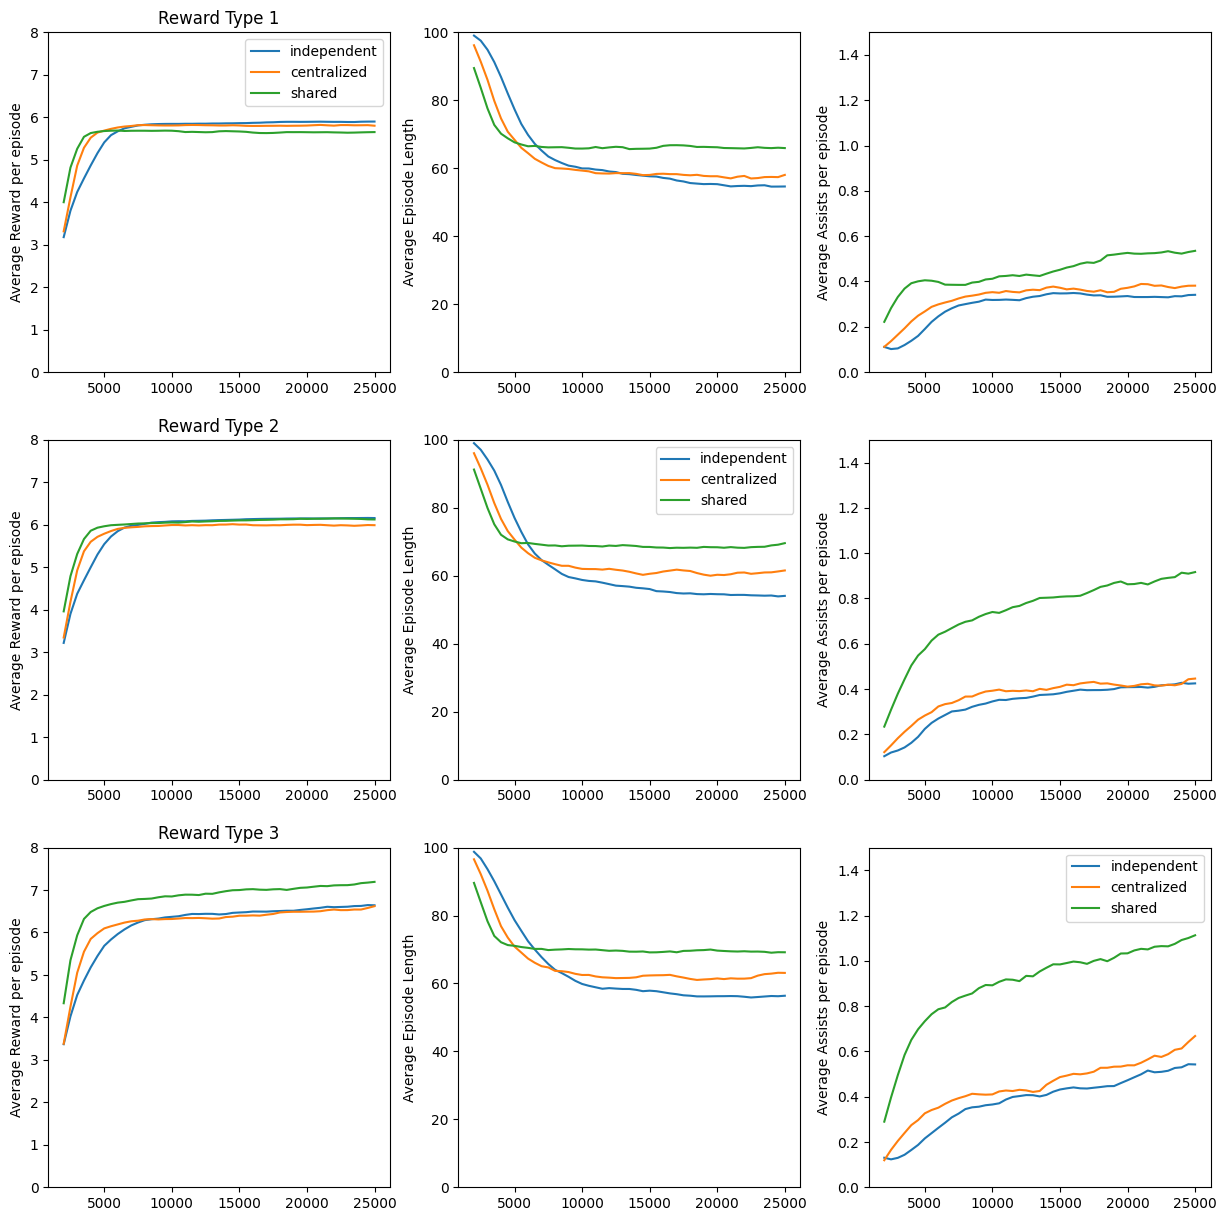

In [43]:
from cProfile import label
from pyparsing import col
from numpy import format_float_positional, size


collated_performances_df = pd.DataFrame(
    [],
    columns = ['step_penalty', 'algorithm_type', 'reward_type', 'lstm',
        'episode_length', 'episode_reward', 'epsiode_assists',\
               'eval_length', 'eval_reward', 'eval_assists']
).fillna(0)

def get_run_graph_data(algo_type, reward_type, step_penalty, use_lstm):
    _run_stats = dict()
    struct_df = pd.DataFrame(
        [],
        index = arange(0, 25001, 500),
        columns = ['episode_reward', 'episode_length', 'episode_assists', 'episodes_total']
    ).fillna(0)
    collated_performances_df = None
    for run in runs:
        config = run.config
        if config['algorithm_type'] != algo_type or \
            config['env_config']['reward_type'] != reward_type or \
            abs(config['env_config']['step_penalty']) != step_penalty or \
            config['training']['model']['use_lstm'] != use_lstm:
            continue
        # if run._state != "finished":
        if run._state != "finished":
            if run._state == "running":
                _run_stats['running_runs'] = _run_stats.get('running_runs', 0) + 1
            else:
                _run_stats['crashed_runs'] = _run_stats.get('crashed_runs', 0) + 1
            continue
        _run_stats['finished_runs'] = _run_stats.get('finished_runs', 0) + 1

        performance_df = struct_df.copy()
        history_df = pd.DataFrame(run._full_history())
        df1 = history_df.loc[:, ['episode_reward_mean', 'episode_len_mean', 'episode_assists_mean', 'episodes_total']].dropna()
        df1.columns = ['episode_reward', 'episode_length', 'episode_assists', 'episodes_total']
        for col in df1.columns:
            if col == 'epsides_total':
                continue
            performance_df[col] = np.interp(struct_df.index, df1['episodes_total'], df1[col])
        
        collated_performances_df = np.dstack([np.array(struct_df), np.array(performance_df)])\
            if collated_performances_df is None else\
                np.dstack([collated_performances_df, np.array(performance_df)])


    if _run_stats.get('finished_runs', 0) == 0:
        return None
    collated_performances_df = collated_performances_df[:, :, 1:]
    collated_performances_df = pd.DataFrame(
        collated_performances_df.mean(-1),
        index = struct_df.index,
        columns = struct_df.columns)
    # collated_performances_df = collated_performances_df.mean(-1)
    # collated_performances_df = pd.DataFrame(collated_performances_df, columns=['episode_reward', 'episode_length', 'episode_assists', 'episodes_total'])
    collated_performances_df = collated_performances_df.rolling(5, axis=0).mean().dropna()
    # print(f"For {algo_type}, {reward_type}, {step_penalty}, {use_lstm}")
    # print(f"F: {_run_stats.get('finished_runs', 0)}, R: {_run_stats.get('running_runs', 0)}, C: {_run_stats.get('crashed_runs', 0)}\n")
    # # collated_performances_df.set_index('episodes_total', inplace=True)    
    return collated_performances_df

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
algo_perf_dfs = []
for algo_type in ALGORITHM_TYPES:
    reward_perf_dfs = []
    for rindex, reward_type in enumerate(REWARD_TYPES):
            step_penalty = 0.0
            # for use_lstm in [True, False]:
            collated_performances_df = get_run_graph_data(algo_type, reward_type, step_penalty, use_lstm)
            if collated_performances_df is None:
                continue
            reward_perf_dfs.append(collated_performances_df)
            ax[rindex][0].plot(
                collated_performances_df.index,
                collated_performances_df['episode_reward'],
                label = algo_type)
            ax[rindex][1].plot(
                collated_performances_df.index,
                collated_performances_df['episode_length'],
                label = algo_type)
            ax[rindex][2].plot(
                collated_performances_df.index,
                collated_performances_df['episode_assists'],
                label = algo_type)
            
            ax[rindex][0].set_title(f"Reward Type {rindex + 1}")
            ax[rindex][0].set_ylim(0, 8)
            ax[rindex][0].set_ylabel("Average Reward per episode")
            ax[rindex][1].set_ylim(0, 100)
            ax[rindex][1].set_ylabel("Average Episode Length")
            ax[rindex][2].set_ylim(0, 1.5)
            ax[rindex][2].set_ylabel("Average Assists per episode")
            df3 = collated_performances_df.copy()
            df3.drop('episodes_total', axis=1, inplace=True)
            df3.columns = [f"{algo_type[0]}_{rindex}_{c[8]}" for c in df3.columns]
            reward_perf_dfs.append(df3)
    df = pd.concat(reward_perf_dfs, axis=1) 
    algo_perf_dfs.append(df)

# with open(f"{RESULTS_DIR}/graph_data.dat", 'w') as f:
#     algo_pref_dfs = pd.concat(algo_perf_dfs, axis=1)
#     algo_pref_dfs.index.name = 'episodes_total'
#     algo_pref_dfs.reset_index(inplace=True)
#     algo_pref_dfs.to_csv(f'{RESULTS_DIR}/test.csv', index=False, float_format=lambda x: format_float_positional(x, precision=2))
#     f.write(algo_pref_dfs.to_string(index=False, float_format=lambda x: format_float_positional(x, precision=2)))
 
ax[0][0].legend()
ax[1][1].legend()
ax[2][2].legend()
fig.show()
# fig.savefig('assists_s0.png')

This cell prints the collated analysis df for each group [step_penalty, algo_type, reward_type] and writes them in files > [r]-[algo_type]_[reward_type]_[step_penalty]

In [84]:
# import re
# RUN_IDS = ["df1702684118", "df1702598855", "df1702595444"]
import re
from numpy import poly, sort
import copy 

def get_analysis_df(algo_type, reward_type, step_penalty, use_lstm):
    file_name_prefix = ""  # _chaser, _fixed, _follower
    _run_stats = dict()
    big_analysis_df = None
    run_history_df = pd.DataFrame(
        [],
        columns=[
            "run_name",
            "trial_count",
            "training_iteration",
            "episodes_total",
            "train_len",
            "train_reward",
            "train_assists",
            "eval_len",
            "eval_reward",
            "eval_assists",
            "analysis_len",
            "analysis_reward",
            "analysis_assists",
        ],
    ).fillna(0)
    eval_df = None
    for run in runs:
        config = run.config
        if (
            config["algorithm_type"] != algo_type
            or config["env_config"]["reward_type"] != reward_type
            or config["env_config"]["step_penalty"] != step_penalty
            or config["training"]["model"]["use_lstm"] != use_lstm
        ):
            continue

        if run._state != "finished":
            if run._state == "running":
                _run_stats["running_runs"] = _run_stats.get("running_runs", 0) + 1
            else:
                _run_stats["crashed_runs"] = _run_stats.get("crashed_runs", 0) + 1
            continue
        _run_stats["finished_runs"] = _run_stats.get("finished_runs", 0) + 1

        if (
            config["algorithm_type"] == algo_type
            and config["env_config"]["reward_type"] == reward_type
            and config["env_config"]["step_penalty"] == step_penalty
            and config["training"]["model"]["use_lstm"] == use_lstm
        ):
            _run_stats["matching_runs"] = _run_stats.get("matching_runs", 0) + 1

            if file_name_prefix == "":
                file_name_prefix = algo_type

            # if len(RUN_IDS) > 0 and run.name not in RUN_IDS:
            #     continue

            for file in run.files():
                if f"{file_name_prefix}_analysis" in file.name:
                    analysis_df = pd.read_json(
                        file.download(exist_ok=True), orient="split"
                    )
                    for file in run.files():
                        if f"{file_name_prefix}_eval" in file.name:
                            eval_stats = pd.read_json(
                                file.download(exist_ok=True), orient="split"
                            )
                        if "fixed" in file.name or "chaser" in file.name:
                            fixed_analysis_df = pd.read_json(
                                file.download(exist_ok=True), orient="split"
                            )
                            analysis_df = pd.concat(
                                [analysis_df, fixed_analysis_df])
                    col_list = (
                        analysis_df.groupby(
                            ["mode", "agent_a", "agent_b", "test", "dimension"]
                        )
                        .count()
                        .columns
                    )
                    agg_funcs = []
                    for col in col_list:
                        if col == "run_id":
                            agg_funcs.append((col, "nunique"))
                        else:
                            agg_funcs.append((col, "mean"))
                    analysis_df = (
                        analysis_df.groupby(
                            ["mode", "agent_a", "agent_b", "test", "dimension"]
                        )
                        .agg(dict(agg_funcs))
                        .reset_index()
                    )
                    analysis_df["trial_count"] = analysis_df["run_id"]
                    analysis_df.drop(columns=["run_id"], inplace=True)
                    analysis_df["run_name"] = run.name
                    analysis_df["episode_len"] = run.summary["episode_len_mean"]
                    analysis_df["episode_reward"] = run.summary["episode_reward_mean"]
                    analysis_df["episode_assists"] = run.summary["episode_assists_mean"]
                    analysis_df["eval_len"] = run.summary["eval_episode_len"]
                    analysis_df["eval_assists"] = run.summary["eval_assists"]
                    analysis_df["eval_reward"] = run.summary["eval_reward"]
                    analysis_df["analysis_len"] = eval_stats["episode_len"].mean()
                    analysis_df["analysis_reward"] = eval_stats["episode_reward"].mean()
                    analysis_df["analysis_assists"] = eval_stats["assists"].mean()


                    big_analysis_df = (
                        pd.concat([big_analysis_df, analysis_df])
                        if big_analysis_df is not None
                        else analysis_df
                    )

                    run_history_df.loc[len(run_history_df)] = [
                        run.name,
                        analysis_df["trial_count"][0],
                        run.summary["training_iteration"],
                        run.summary["episodes_total"],
                        run.summary["episode_len_mean"],
                        run.summary["episode_reward_mean"],
                        run.summary["episode_assists_mean"],
                        run.summary["eval_episode_len"],
                        run.summary["eval_reward"],
                        run.summary["eval_assists"],
                        eval_stats["episode_len"].mean(),
                        eval_stats["episode_reward"].mean(),
                        eval_stats["assists"].mean(),
                    ]
    if len(run_history_df) == 0:
        return None, None, _run_stats, None

    grouped = big_analysis_df.copy()
    grouped = grouped.groupby(["mode", "agent_a", "agent_b", "test", "dimension"])

    big_analysis_df.drop(
        columns=[
            "episode_len",
            "episode_reward",
            "episode_assists",
            "eval_len",
            "eval_reward",
            "eval_assists",
            "analysis_len",
            "analysis_reward",
            "analysis_assists"
        ],
        inplace=True,
    )
    col_list = (
        big_analysis_df.groupby(["mode", "agent_a", "agent_b", "test", "dimension"])
        .count()
        .columns
    )
    agg_funcs = []
    for col in col_list:
        if col == "run_name":
            agg_funcs.append((col, "nunique"))
        elif col == "trial_count":
            agg_funcs.append((col, "sum"))
        else:
            agg_funcs.append((col, "mean"))

    big_analysis_df = big_analysis_df.groupby(
        ["mode", "agent_a", "agent_b", "test", "dimension"]
    ).agg(dict(agg_funcs))
    run_history_df.set_index("run_name", inplace=True)
    return big_analysis_df, run_history_df, _run_stats, grouped


_color_dict = {
    "type_1": "red",
    "type_2": "blue",
    "type_3": "green",
}
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
grouped_dfs_dict = dict()
for aindex, algo_type in enumerate(ALGORITHM_TYPES):
    for rindex, reward_type in enumerate(REWARD_TYPES):
        for step_penalty in [-0.01]:
            for use_lstm in [False]:
                analysis_df, run_history_df, _run_stats, grouped = get_analysis_df(
                    algo_type, reward_type, step_penalty, use_lstm
                )
                print(f"{algo_type}, {reward_type}, {step_penalty}: {_run_stats}")

                if analysis_df is None:
                    continue

                grouped_dfs_dict[(algo_type, reward_type, step_penalty)] = copy.deepcopy(grouped)

                df1 = grouped.get_group(
                    (algo_type, "predator_0", "predator_1", "ccm_1", "dx")
                )[["5000", "analysis_assists"]]
                x = df1["analysis_assists"]
                y = df1["5000"]
                # Add scatterplot
                axs[0, aindex].scatter(
                    x,
                    y,
                    s=10,
                    alpha=0.5,
                    color=_color_dict[reward_type], )
                results = np.polyfit(x, y, deg=2)
                poly_function = np.poly1d(results)
                axs[0, aindex].plot(sorted(x), poly_function(sorted(x)), color=_color_dict[reward_type], lw=1)
                axs[0, aindex].set_ylim(0, 0.8)
                axs[0, aindex].set_title(f"{algo_type}_DX")
                ## DY _PLOT
                df1 = grouped.get_group(
                    (algo_type, "predator_0", "predator_1", "ccm_1", "dy")
                )[["5000", "analysis_assists"]]
                x = df1["analysis_assists"]
                y = df1["5000"]
                # Add scatterplot
                axs[1, aindex].scatter(
                    x,
                    y,
                    s=10,
                    alpha=0.5,
                    color=_color_dict[reward_type],)
                results = np.polyfit(x, y, deg=1)
                poly_function = np.poly1d(results)
                axs[1, aindex].plot(sorted(x), poly_function(sorted(x)), color=_color_dict[reward_type], lw=1)
                axs[1, aindex].set_ylim(0, 0.8)
                axs[1, aindex].set_title(f"{algo_type}_DY")
                # PCA PLOT 
                df1 = grouped.get_group(
                    (algo_type, "predator_0", "predator_1", "ccm_1", "PCA_2")
                )[["5000", "analysis_assists"]]
                x = df1["analysis_assists"]
                y = df1["5000"]
                # Add scatterplot
                axs[2, aindex].scatter(
                    x,
                    y,
                    s=10,
                    alpha=0.5,
                    color=_color_dict[reward_type],)
                results = np.polyfit(x, y, deg=1)
                poly_function = np.poly1d(results)
                axs[2, aindex].plot(sorted(x), poly_function(sorted(x)), color=_color_dict[reward_type], lw=1)
                axs[2, aindex].set_ylim(0.1, 0.9)
                axs[2, aindex].set_title(f"{algo_type}_PCA")

                # # stop
                # import signal
                # signal.raise_signal(signal.SIGINT)
                # file_name = f"{algo_type}_{reward_type}_{step_penalty}"
                # if use_lstm:
                #     file_name = "r-" + file_name
                # # Create dat files here and write to results/data

                # file_name = project + "_" + file_name + ".txt"
                # import warnings

                # warnings.warn("Overwriting filename")
                # file_name = "rnn_test.txt"
                # with open(f"{RESULTS_DIR}/{file_name}", "a") as f:
                #     descr = f"""{algo_type}, {reward_type}, {step_penalty}: {_run_stats}
                #     COMPLETED RUNS: {_run_stats.get('finished_runs', 0)}
                #     RUNNING RUNS: {_run_stats.get('running_runs', 0)}
                #     CRASHED RUNS: {_run_stats.get('crashed_runs', 0)}
                #     TOTAL = {_run_stats.  get('finished_runs', 0) + _run_stats.get('running_runs', 0) + _run_stats.get('crashed_runs', 0)}
                #     \nBASE PERFORMANCE: {run_history_df.mean()}
                #     """
                #     # print(descr)
                #     f.write(descr)
                #     f.write(analysis_df.to_string())
                #     f.write(run_history_df.to_string())
                # print(f"Added to {file_name}")

fig.savefig('analysis_assists_s0_d2.png')

independent, type_1, -0.01: {'running_runs': 6, 'crashed_runs': 10, 'finished_runs': 20, 'matching_runs': 20}
independent, type_2, -0.01: {'running_runs': 4, 'crashed_runs': 15, 'finished_runs': 20, 'matching_runs': 20}
independent, type_3, -0.01: {'running_runs': 5, 'crashed_runs': 12, 'finished_runs': 22, 'matching_runs': 22}
centralized, type_1, -0.01: {'running_runs': 8, 'crashed_runs': 9, 'finished_runs': 21, 'matching_runs': 21}
centralized, type_2, -0.01: {'running_runs': 6, 'crashed_runs': 11, 'finished_runs': 20, 'matching_runs': 20}
centralized, type_3, -0.01: {'running_runs': 5, 'crashed_runs': 11, 'finished_runs': 20, 'matching_runs': 20}
shared, type_1, -0.01: {'running_runs': 1, 'crashed_runs': 19, 'finished_runs': 23, 'matching_runs': 23}


KeyboardInterrupt: 

KeyError: ('independent', 'type_1', 0.01)

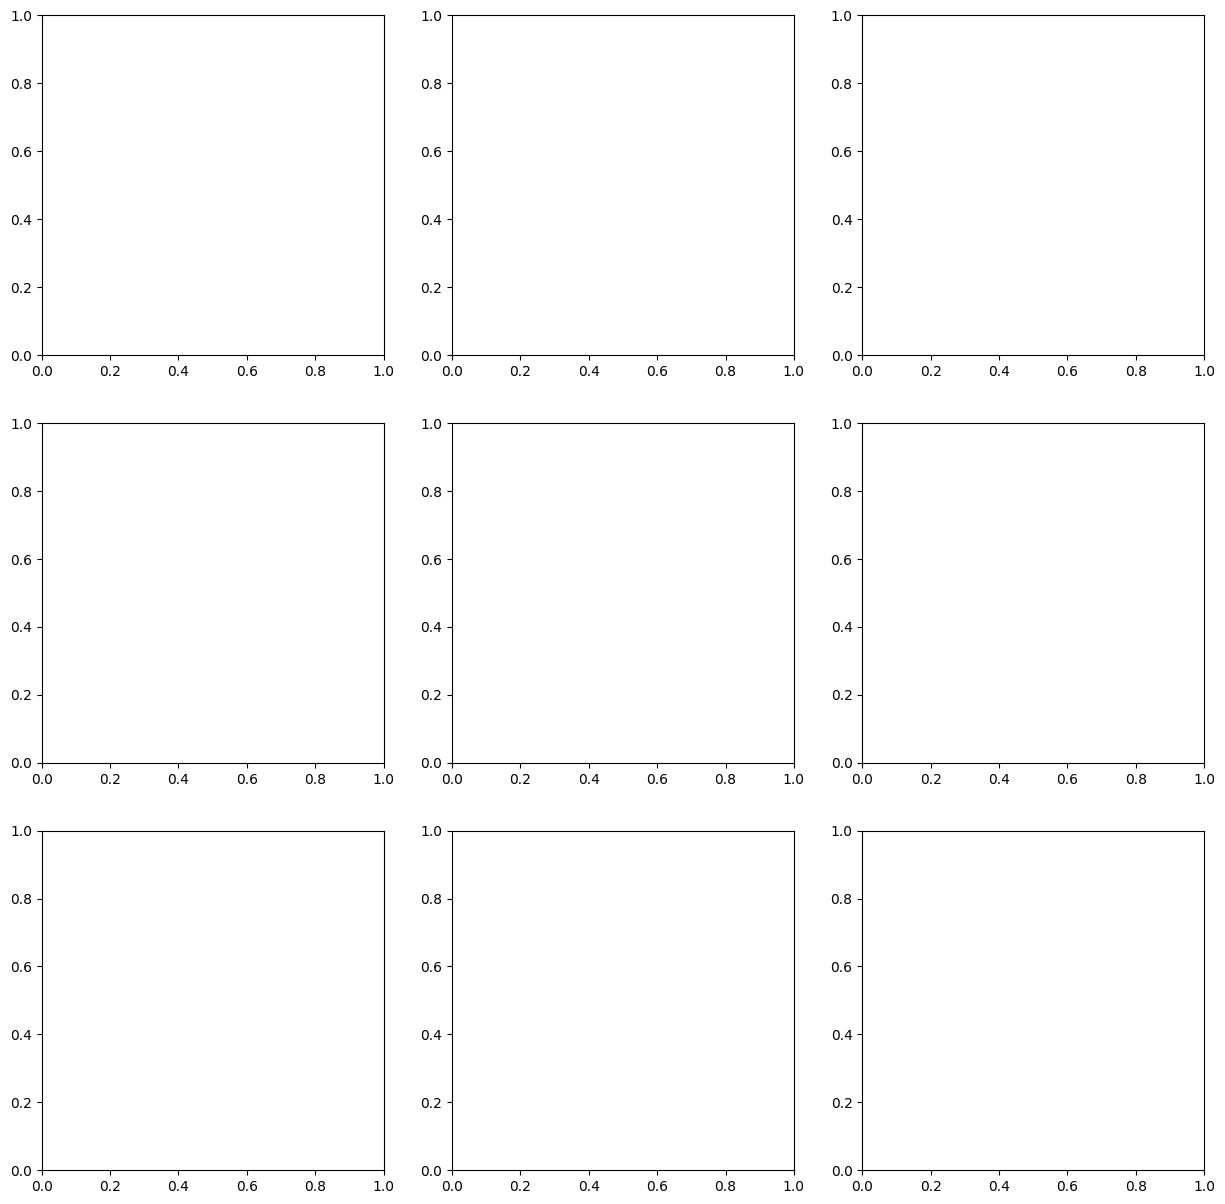

In [82]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for aindex, algo_type in enumerate(ALGORITHM_TYPES):
    for rindex, reward_type in enumerate(REWARD_TYPES):
        for step_penalty in [0.01]:
            grouped = grouped_dfs_dict[(algo_type, reward_type, step_penalty)]
            df1 = grouped.get_group(
                    (algo_type, "predator_0", "predator_1", "ccm_1", "dx")
                )[["5000", "analysis_assists"]]
            x = df1["analysis_assists"]
            y = df1["5000"]
                # Add scatterplot
            axs[0, aindex].scatter(
                    x,
                    y,
                    s=10,
                    alpha=0.5,
                    color=_color_dict[reward_type], )
            results = np.polyfit(x, y, deg=2)
            poly_function = np.poly1d(results)
            axs[0, aindex].plot(sorted(x), poly_function(sorted(x)), color=_color_dict[reward_type], lw=1)
            axs[0, aindex].set_ylim(0, 0.8)
            axs[0, aindex].set_title(f"{algo_type}_DX")
            ## DY _PLOT
            df1 = grouped.get_group(
                (algo_type, "predator_0", "predator_1", "ccm_1", "dy")
            )[["5000", "analysis_assists"]]
            x = df1["analysis_assists"]
            y = df1["5000"]
            # Add scatterplot
            axs[1, aindex].scatter(
                x,
                y,
                s=10,
                alpha=0.5,
                color=_color_dict[reward_type],)
            results = np.polyfit(x, y, deg=2)
            poly_function = np.poly1d(results)
            axs[1, aindex].plot(sorted(x), poly_function(sorted(x)), color=_color_dict[reward_type], lw=1)
            axs[1, aindex].set_ylim(0, 0.8)
            axs[1, aindex].set_title(f"{algo_type}_DY")
            # PCA PLOT 
            df1 = grouped.get_group(
                (f"{algo_type}_fixed", "predator_0", "predator_1", "ccm_1", "PCA_2")
            )[["5000", "analysis_assists"]]
            x = df1["analysis_assists"]
            y = df1["5000"]
            # Add scatterplot
            axs[2, aindex].scatter(
                x,
                y,
                s=10,
                alpha=0.5,
                color=_color_dict[reward_type],)
            results = np.polyfit(x, y, deg=2)
            poly_function = np.poly1d(results)
            axs[2, aindex].plot(sorted(x), poly_function(sorted(x)), color=_color_dict[reward_type], lw=1)
            axs[2, aindex].set_ylim(0.1, 0.9)
            axs[2, aindex].set_title(f"{algo_type}_PCA")

fig.savefig('../results/analysis_assists_s1_d2.png')

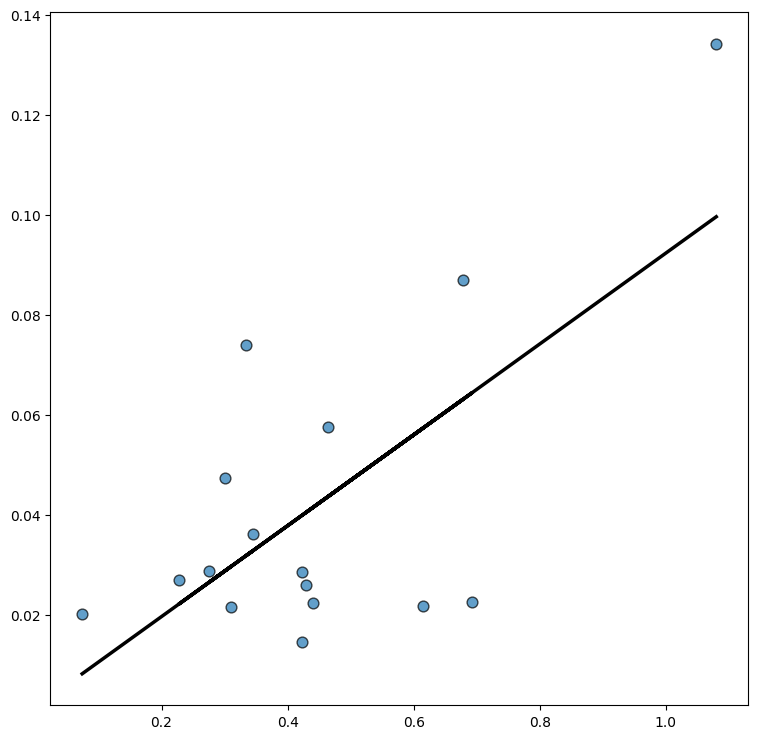

In [69]:
import matplotlib.pyplot as plt
df1 = grouped.get_group(('centralized', 'predator_0', 'predator_1', 'ccm_1', 'dx'))[['5000', 'eval_assists']]
# df1.plot(x = 'eval_assists', y = '5000', kind = 'scatter')
# plt.show()
# plt.savefig('indp_r2_s3.png')
# Generate data
import numpy as np
x = df1['eval_assists']
y = df1['5000']
# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100 

# Plot regression line
ax.plot(x, a + b * x, color="k", lw=2.5)

41


<Axes: xlabel='eval_assists'>

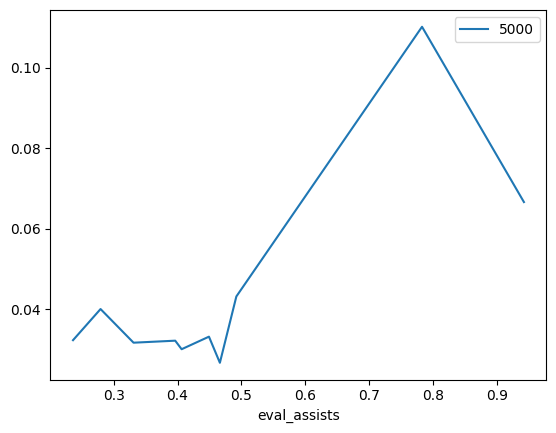

In [20]:
# Adjust these parameters as needed
window_size = 3  # Adjust the size of the rolling window
stride = 2       # Adjust the stride

df = df1.loc[:, ['5000', 'eval_assists']].copy()
df.sort_values(by=['eval_assists'], inplace=True)

# Adjust these parameters based on the desired number of data points (e.g., 10)
desired_data_points = 10
window_size = len(df) // desired_data_points  # Adjust the window size
stride = window_size  # Set the stride to the window size

# Apply rolling window and custom function
print(len(df))
result = df.rolling(window=window_size).apply(lambda x: x.mean(), raw=False)
result.dropna(inplace=True)
sampled_result = result.sample(n=desired_data_points)
sampled_result.sort_values(by=['eval_assists'], inplace=True)
sampled_result.plot(x = 'eval_assists', y = '5000', kind = 'line')

y = 0.03664 * x + -0.00870 * x^2 + 0.03374


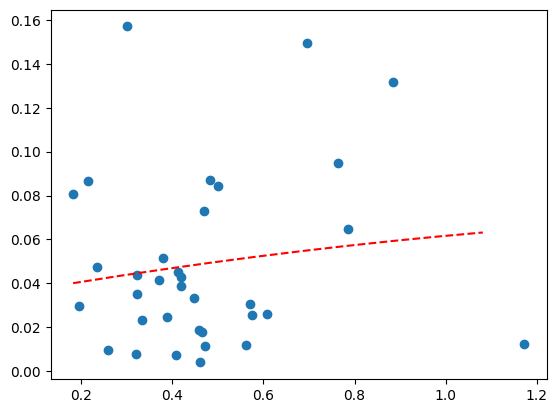

In [82]:
from scipy.optimize import curve_fit
from numpy import arange 
import matplotlib.pyplot as plt

# define the true objective function
def objective(x, a, b, c):
	return a * x + b * x**2 + c

x = df1['eval_assists']
y = df1['5000']
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c = popt
print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
# plot input vs output
plt.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 0.1)
# calculate the output for the range
y_line = objective(x_line, a, b, c)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '--', color='red')
plt.show()

In [1]:
# simple solution that works; use it to verfiy results 
file_name_prefix = "" # _chaser, _fixed, _follower
_run_stats = dict()
collated_df = None
eval_df = None
for run in runs:
    # if run._state != "finished":
    if run._state != "finished":
        if run._state == "running":
            _run_stats['running_runs'] = _run_stats.get('running_runs', 0) + 1
        else:
            _run_stats['crashed_runs'] = _run_stats.get('crashed_runs', 0) + 1
        continue
    _run_stats['finished_runs'] = _run_stats.get('finished_runs', 0) + 1

    config = run.config
    if config['algorithm_type'] == ALGORITHM_TYPE and \
        config['env_config']['reward_type'] == REWARD_TYPE:
        _run_stats['matching_runs'] = _run_stats.get('matching_runs', 0) + 1

        if file_name_prefix == "":
            file_name_prefix = ALGORITHM_TYPE

        for file in run.files():
            if f"{file_name_prefix}_analysis" in file.name:
                analysis_table = pd.read_json(
                    file.download(exist_ok=True), 
                    orient='split')
                if collated_df is None:
                    collated_df = analysis_table
                else:
                    collated_df = pd.concat([collated_df, analysis_table])
            elif f"{file_name_prefix}_eval_df" in file.name:
                eval_stats = pd.read_json(
                    file.download(exist_ok=True), 
                    orient='split')
                if eval_df is None:
                    eval_df = eval_stats
                else:
                    eval_df = pd.concat([eval_df, eval_stats])
grouped_by_runs = collated_df.groupby(['mode', 'agent_a', 'test', 'dimension'])
grouped_by_runs[[str(i) for i in range(500, 5001, 500)]].agg(['mean', 'std', 'count'])

NameError: name 'runs' is not defined

In [23]:
# results from fixed strategies; CALIBRATION
TEST_NAME = "ccm_1"
POLICY_SETS = ["chaser_chaser", "chaser_fixed", "chaser_follower", "fixed_follower", "follower_chaser"]
grouped_dfs = []
eval_dfs = None
for policy_set in POLICY_SETS:
    analyis_df = pd.read_csv(f"../experiments/results/{policy_set}_analysis.csv")
    eval_df = pd.read_csv(f"../experiments/results/{policy_set}_eval.csv")
    col_list = list(analyis_df.groupby(['mode', 'agent_a', 'agent_b', 'test', 'dimension']).mean().columns)
    agg_funs = []
    for col in col_list:
        if col != 'run_id':
            agg_funs.append((col, lambda x: round(x.mean(), 2)))
        else:
            agg_funs.append((col, 'count'))
        
    df2 = analyis_df.groupby(['mode', 'agent_a', 'agent_b', 'test', 'dimension']).agg(dict(agg_funs))
    grouped_dfs.append(df2) 
    eval_dfs = pd.concat([
        eval_dfs,
        pd.DataFrame([dict(name=policy_set,**dict(eval_df.mean()))])
    ]) if eval_dfs is not None else pd.DataFrame([dict(name=policy_set,**dict(eval_df.mean()))])

    if policy_set in ["chaser_chaser", "chaser_fixed", "chaser_follower"]:
        for dim in ["dx", "dy", "PCA_2"]:
            new_data = df2.loc[policy_set, 'predator_0', :, TEST_NAME, dim].T[1:]
            new_data.index.name = 'X'
            new_data.columns = [dim]
            dat_file = f"../results/data/{TEST_NAME}_{policy_set}_{dim}.dat"
            new_data.to_csv(dat_file, sep=' ')

eval_dfs.set_index('name', inplace=True)
with open("fixed_results.txt", "w") as f:
    f.write("EVALUATION simple map size 15, reward type 1, step penalty None\n")
    f.write(eval_dfs.to_string())
    f.write("\n\n")
    for df in grouped_dfs:
        f.write(df.to_string())
        f.write("\n\n")